
## Introduction

Satellite imagery is being used together with AI and deep learning in [many areas](2021-05-14-ai-satellite-images.html) to produce stunning insights and discoveries. In this project I look at applying this approach to recognising buildings, woodlands & water areas from satellite images.

## Dataset

The [dataset](https://landcover.ai) used for this project comes from the research paper [LandCover.ai: Dataset for Automatic Mapping of Buildings, Woodlands and Water from Aerial Imagery](https://arxiv.org/pdf/2005.02264.pdf) which gathered satellite imagery of different areas of Poland. The satellite images have 3 spectral bands so are RGB jpg images. The researchers chose to use 4 classes for identifying objects in these images:

- Building
- Woodland
- Water
- Background (i.e. everything else)

This is an *image segmentation* dataset, so the classes are expressed as colourmap shading by pixels for parts of the image that correspond to each class. These image colourmap/masks for the classes are represented as a png image, one of each of the satellite images.

## Methodology

For this project I used the fastai deep learning library which is based on Pytorch/Python. The dataset lends itself to the approach of *image segmentation classification* as the classes in the dataset are expressed as shaded regions, as opposed to say multi-label image classification using text labels. For this approach, the [UNET](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47) deep learning architecture has prooven extremely good for image segmentation problems - which is what I chose to use here.


In [ ]:
#| include: false
!pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 20.6MB/s 
     |████████████████████████████████| 12.8MB 240kB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
#| include: false
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#| include: false
!unzip "/content/gdrive/My Drive/Datasets/LandCoverData.zip"
!mkdir LandCoverData/images
!mkdir LandCoverData/labels
!mv LandCoverData/M*.jpg LandCoverData/images
!mv LandCoverData/N*.jpg LandCoverData/images
!mv LandCoverData/M*.png LandCoverData/labels
!mv LandCoverData/N*.png LandCoverData/labels

Streaming output truncated to the last 5000 lines.
  inflating: LandCoverData/N-34-106-A-b-3-4_307.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_307_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_308.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_308_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_309.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_309_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_30_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_31.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_310.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_310_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_311.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_311_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_312.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_312_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_313.jpg  
  inflating: LandCoverData/N-34-106-A-b-3-4_313_m.png  
  inflating: LandCoverData/N-34-106-A-b-3-4_314.jpg  
  inflating: Land

In [ ]:
#| include: false
import os
import numpy as np
import glob
import shutil

from fastai.vision.all import *

In [ ]:
#| include: false
ROOT_PATH = ""
DATA_PATH = os.path.join(ROOT_PATH, "LandCoverData")
DATA_ZIP_PATH = os.path.join(ROOT_PATH, "LandCoverData.zip")
IMAGE_PATH = os.path.join(ROOT_PATH, "Images")
LABEL_PATH = os.path.join(ROOT_PATH, "Targets")

BATCH_SIZE = 4

## Prepare and load data



In [ ]:

## Set path for image files
path = Path(DATA_PATH)
## Set the text for the classes
codes = np.array(["building", "woodland", "water", "Background"])

In [ ]:

## Load image files from the path
fnames = get_image_files(path/"images")
## Define a function to get the label png file
def label_func(fn): 
  return path/"labels"/f"{fn.stem}_m{'.png'}"

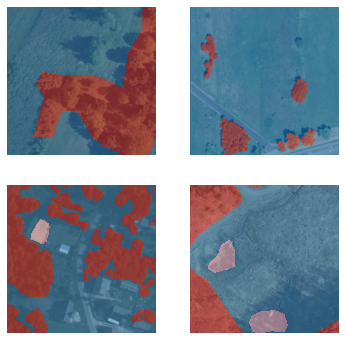

In [ ]:

## Create a data loader for this image segmentation dataset
dls = SegmentationDataLoaders.from_label_func(
    path, bs=BATCH_SIZE, fnames = fnames, label_func = label_func, codes = codes
)
## Show a batch of images
dls.show_batch()

So we can see a nice feature of the fastai library is able to combine the original satellite image overlayed with the colourmap for the class labels with some transparency so we can see the image and labels together.

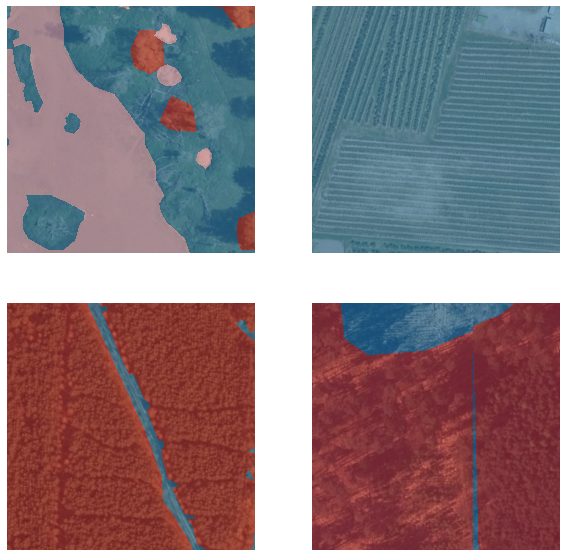

In [ ]:
## Show some more images
dls.show_batch(figsize=(10,10))

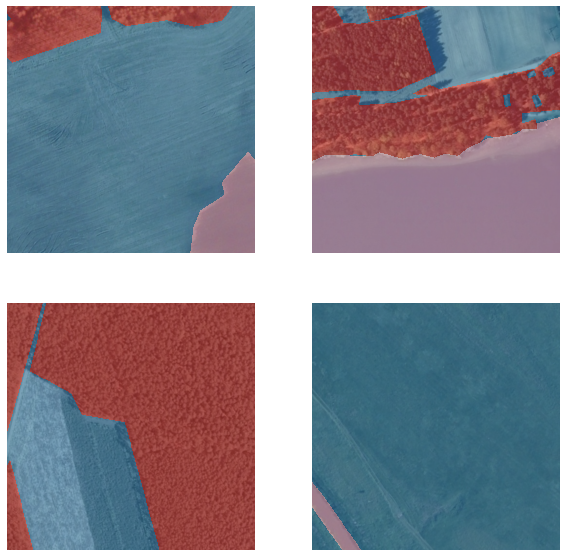

In [ ]:
## Show some more images
dls.show_batch(figsize=(10,10))

## Training the UNET model

In [ ]:
#| include: false
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,time
0,0.425658,0.249241,26:51


epoch,train_loss,valid_loss,time
0,0.207543,0.165862,27:07
1,0.173056,0.227951,27:02
2,0.128388,0.140451,27:00


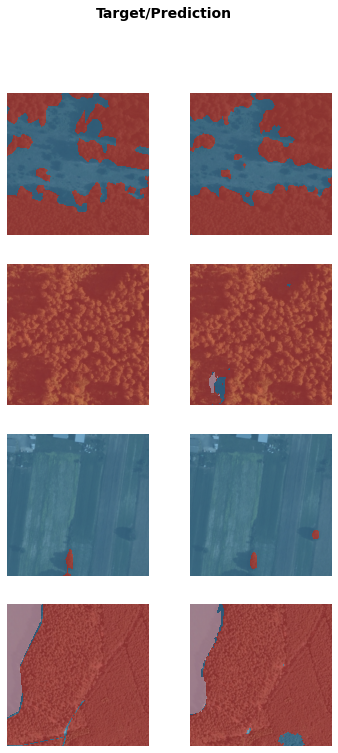

In [ ]:

## Create a UNET model using the resnet18 architecture
learn = unet_learner(dls, resnet18)
## Train the model
learn.fine_tune(3)

## Show the results
learn.show_results()

So fastai's *fine_tune()* method will first freeze all but the last layer and train for 1 epoch, and then train for the specified number of epochs (3 in our case). Because image segmentation datasets are particularly big, these can take quite a while to train even on a GPU. In this case 1+3 epochs has taken around 2 hours of training time.

We can see though in this time both the training and validation loss have come down quite nicely, even after 4 epochs. Looking at our results we can see our UNET model has done extremely well when tested on validation images not previosuly seen by the model in the Target/Prediction pair examples above.

Lets see some more tests and results.

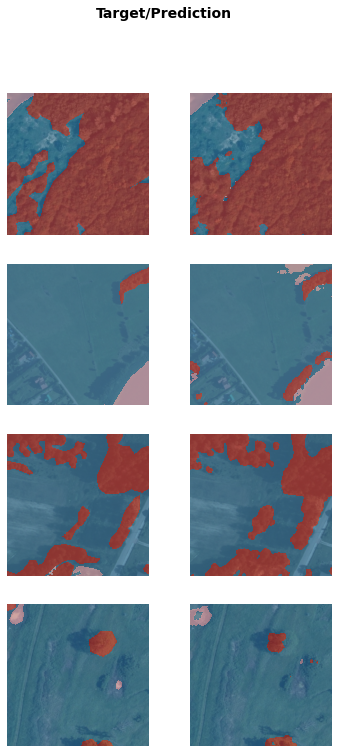

In [ ]:
## Show more results
learn.show_results()

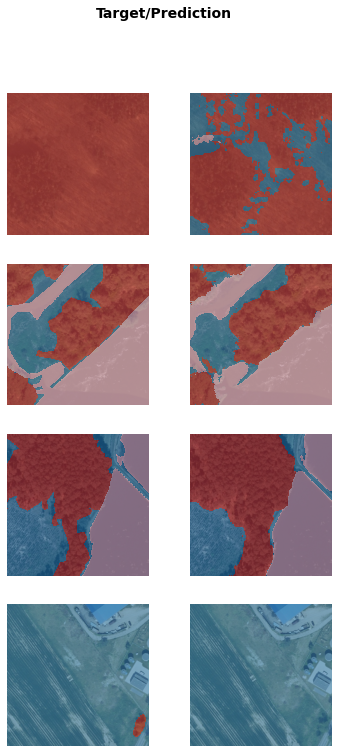

In [ ]:
## Show more results
learn.show_results(max_n=4)

The model does seem to have generally done a good job at predicting the correct classes in the image for a wide range of different satellite image types and conditions.

## Conclusion

In this project we have looked at a satellite image segmentation dataset and have achieved good results from only a limited amount of training.